**1.Maternal Health Risk**
**START**

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load UCI Maternal Health Risk dataset
df = pd.read_csv("Maternal Health Risk Data Set.csv")  # e.g. downloaded CSV
X = df.drop("RiskLevel", axis=1)   # features
y = df["RiskLevel"]               # target

# Check for missing values
print(df.isnull().sum())

# Encode target (if not numeric)
y = y.map({"low risk": 0, "mid risk": 1, "high risk": 2})  # example mapping

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64


In [2]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)
print("Before:", y_train.value_counts(), "After:", pd.Series(y_resampled).value_counts())


Before: RiskLevel
0    325
1    269
2    217
Name: count, dtype: int64 After: RiskLevel
0    325
1    325
2    325
Name: count, dtype: int64


In [3]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Define models
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
xgb = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss')

# Cross-validate on training data (e.g. 5-fold stratified)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_scores = cross_val_score(rf, X_resampled, y_resampled, cv=cv, scoring='roc_auc')
xgb_scores = cross_val_score(xgb, X_resampled, y_resampled, cv=cv, scoring='roc_auc')
print("RF AUC:", rf_scores.mean(), "XGB AUC:", xgb_scores.mean())

# Fit final models
rf.fit(X_resampled, y_resampled)
xgb.fit(X_resampled, y_resampled)


C:\Users\KIIT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\KIIT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_scorer.py", line 152, in __call__
    score = scorer._score(
  File "C:\Users\KIIT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "C:\Users\KIIT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\_param_val

RF AUC: nan XGB AUC: nan


C:\Users\KIIT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\training.py:183: UserWarning: [16:43:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [6]:
# Calculate and print training and test accuracy for RandomForest and XGBoost

# Predictions on training (resampled) set
from sklearn.metrics import accuracy_score


y_train_pred_rf = rf.predict(X_resampled)
y_train_pred_xgb = xgb.predict(X_resampled)

# Predictions on test set (scaled)
y_test_pred_rf = rf.predict(X_test_scaled)
y_test_pred_xgb = xgb.predict(X_test_scaled)

# Compute accuracy
train_acc_rf = accuracy_score(y_resampled, y_train_pred_rf)
test_acc_rf = accuracy_score(y_test, y_test_pred_rf)

train_acc_xgb = accuracy_score(y_resampled, y_train_pred_xgb)
test_acc_xgb = accuracy_score(y_test, y_test_pred_xgb)

print(f"RandomForest - Train Accuracy: {train_acc_rf:.4f}  Test Accuracy: {test_acc_rf:.4f}")
print(f"XGBoost      - Train Accuracy: {train_acc_xgb:.4f}  Test Accuracy: {test_acc_xgb:.4f}")

RandomForest - Train Accuracy: 0.9395  Test Accuracy: 0.8473
XGBoost      - Train Accuracy: 0.9395  Test Accuracy: 0.8571


RandomForest CV accuracy: 0.8369 ± 0.0127
XGBoost CV accuracy: 0.8400 ± 0.0170
Best RF params: {'n_estimators': 100, 'min_samples_leaf': 1, 'max_features': 0.5, 'max_depth': 20}
Test accuracy (best RF): 0.8522167487684729
              precision    recall  f1-score   support

           0       0.87      0.81      0.84        81
           1       0.79      0.81      0.80        67
           2       0.90      0.96      0.93        55

    accuracy                           0.85       203
   macro avg       0.85      0.86      0.86       203
weighted avg       0.85      0.85      0.85       203



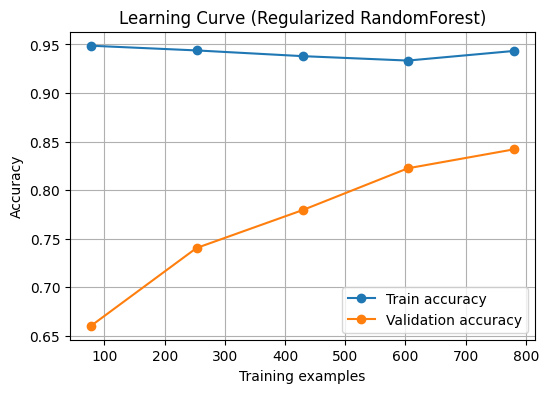

Confusion Matrix (best RF):
[[66 14  1]
 [ 8 54  5]
 [ 2  0 53]]


In [7]:
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, learning_curve
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Evaluate overfitting and try regularizing RandomForest with randomized search + learning curve
import matplotlib.pyplot as plt

# 1) CV accuracy on resampled training set
for name, model in [('RandomForest', rf), ('XGBoost', xgb)]:
    scores = cross_val_score(model, X_resampled, y_resampled, cv=cv, scoring='accuracy', n_jobs=-1)
    print(f"{name} CV accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

# 2) Randomized search to reduce RF complexity (regularize to reduce overfitting)
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', 0.5]
}
rs = RandomizedSearchCV(rf, param_dist, n_iter=20, cv=cv, scoring='accuracy', n_jobs=-1, random_state=42)
rs.fit(X_resampled, y_resampled)
print("Best RF params:", rs.best_params_)

best_rf = rs.best_estimator_
y_test_pred_best = best_rf.predict(X_test_scaled)

print("Test accuracy (best RF):", (y_test_pred_best == y_test).mean())
print(classification_report(y_test, y_test_pred_best))

# 3) Learning curve to inspect gap between train and validation as training size grows
train_sizes, train_scores, val_scores = learning_curve(
    best_rf, X_resampled, y_resampled, cv=cv,
    train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy', n_jobs=-1
)
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_mean, 'o-', label='Train accuracy')
plt.plot(train_sizes, val_mean, 'o-', label='Validation accuracy')
plt.xlabel('Training examples')
plt.ylabel('Accuracy')
plt.title('Learning Curve (Regularized RandomForest)')
plt.legend()
plt.grid(True)
plt.show()

# 4) Confusion matrix for quick error inspection
print("Confusion Matrix (best RF):")
print(confusion_matrix(y_test, y_test_pred_best))


=== RandomForest ===
Accuracy: 0.8522
              precision    recall  f1-score   support

           0       0.87      0.81      0.84        81
           1       0.79      0.81      0.80        67
           2       0.90      0.96      0.93        55

    accuracy                           0.85       203
   macro avg       0.85      0.86      0.86       203
weighted avg       0.85      0.85      0.85       203



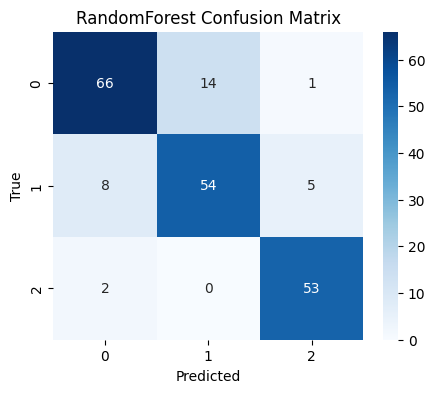

C:\Users\KIIT\AppData\Local\Temp\ipykernel_17436\1615836138.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[idx], y=feature_names[idx], palette="viridis")


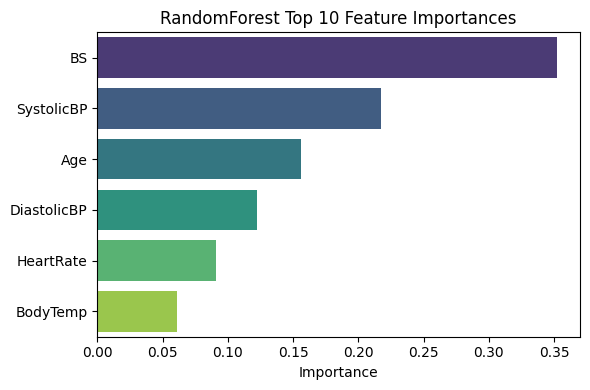

ROC AUC (macro, OVR): 0.9466


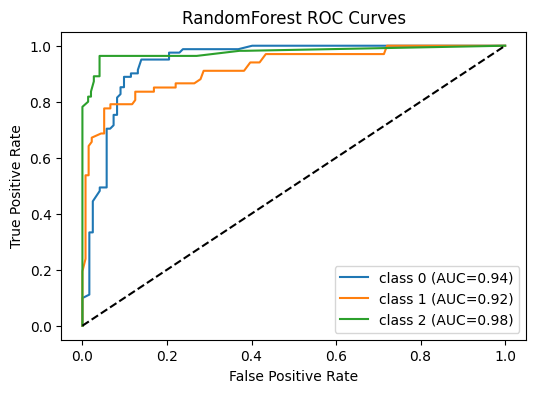


=== XGBoost ===
Accuracy: 0.8571
              precision    recall  f1-score   support

           0       0.86      0.84      0.85        81
           1       0.82      0.79      0.80        67
           2       0.90      0.96      0.93        55

    accuracy                           0.86       203
   macro avg       0.86      0.86      0.86       203
weighted avg       0.86      0.86      0.86       203



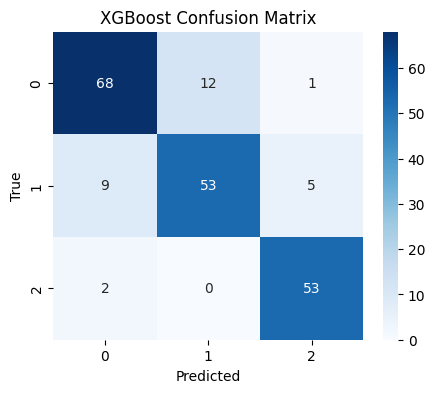

C:\Users\KIIT\AppData\Local\Temp\ipykernel_17436\1615836138.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[idx], y=feature_names[idx], palette="viridis")


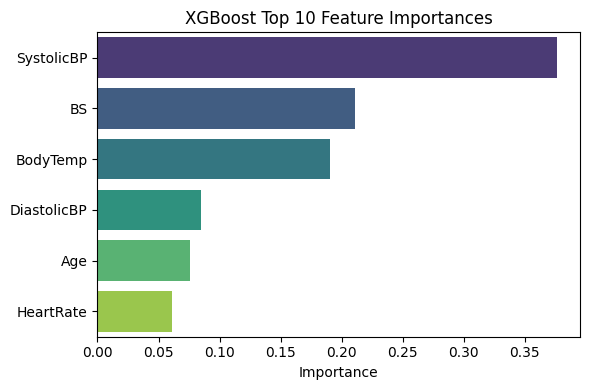

ROC AUC (macro, OVR): 0.9486


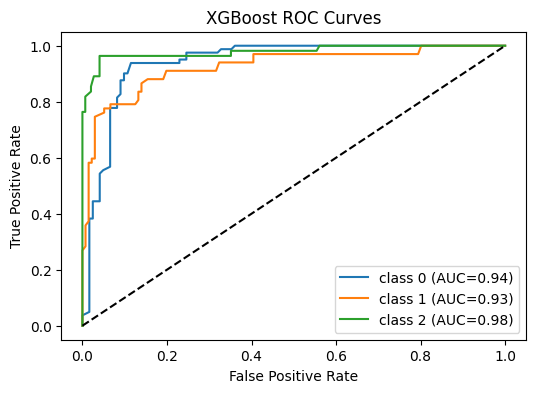

In [8]:
import numpy as np
import seaborn as sns
from sklearn.preprocessing import label_binarize

# Evaluation cell: run after models are trained (best_rf and xgb) and scaler/X_test_scaled/y_test exist
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve, auc
)

models = {"RandomForest": best_rf, "XGBoost": xgb}
y_true = np.array(y_test)
n_classes = len(np.unique(y_true))
y_test_binarized = label_binarize(y_true, classes=np.arange(n_classes))

feature_names = np.array(X.columns)

for name, m in models.items():
    print(f"\n=== {name} ===")
    y_pred = m.predict(X_test_scaled)
    print("Accuracy:", f"{accuracy_score(y_true, y_pred):.4f}")
    print(classification_report(y_true, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=[f"{i}" for i in range(n_classes)],
                yticklabels=[f"{i}" for i in range(n_classes)])
    plt.title(f"{name} Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("True")
    plt.show()

    # Feature importances (top 10) if available
    if hasattr(m, "feature_importances_"):
        importances = m.feature_importances_
        idx = np.argsort(importances)[::-1][:10]
        plt.figure(figsize=(6,4))
        sns.barplot(x=importances[idx], y=feature_names[idx], palette="viridis")
        plt.title(f"{name} Top 10 Feature Importances")
        plt.xlabel("Importance"); plt.tight_layout(); plt.show()

    # ROC AUC (multiclass OVR) and per-class ROC curves if predict_proba exists
    if hasattr(m, "predict_proba"):
        y_score = m.predict_proba(X_test_scaled)
        try:
            roc_auc = roc_auc_score(y_test_binarized, y_score, average="macro", multi_class="ovr")
            print("ROC AUC (macro, OVR):", f"{roc_auc:.4f}")
            plt.figure(figsize=(6,4))
            for i in range(n_classes):
                fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
                plt.plot(fpr, tpr, label=f"class {i} (AUC={auc(fpr,tpr):.2f})")
            plt.plot([0,1],[0,1],"k--")
            plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
            plt.title(f"{name} ROC Curves"); plt.legend(); plt.show()
        except Exception as e:
            print("ROC AUC computation failed:", e)
    else:
        print(f"{name} does not implement predict_proba(); skipping ROC AUC")


--- BestRF ---
              precision    recall  f1-score   support

         low       0.87      0.81      0.84        81
         mid       0.79      0.81      0.80        67
        high       0.90      0.96      0.93        55

    accuracy                           0.85       203
   macro avg       0.85      0.86      0.86       203
weighted avg       0.85      0.85      0.85       203


--- RandomForest ---
              precision    recall  f1-score   support

         low       0.87      0.80      0.83        81
         mid       0.79      0.81      0.80        67
        high       0.88      0.96      0.92        55

    accuracy                           0.85       203
   macro avg       0.85      0.86      0.85       203
weighted avg       0.85      0.85      0.85       203


--- XGBoost ---
              precision    recall  f1-score   support

         low       0.86      0.84      0.85        81
         mid       0.82      0.79      0.80        67
        high       0

,accuracy,balanced_accuracy,precision_macro,recall_macro,f1_macro,cohen_kappa
model,,,,,,
BestRF,0.8522,0.8615,0.8536,0.8615,0.8569,0.7765
RandomForest,0.8473,0.8574,0.8480,0.8574,0.8517,0.7693
XGBoost,0.8571,0.8647,0.8581,0.8647,0.8610,0.7836


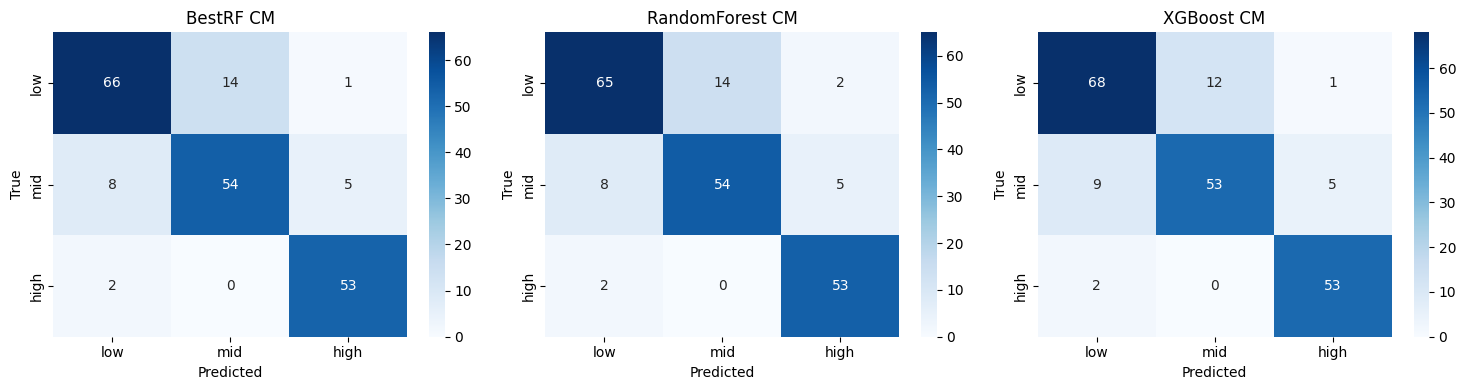

BestRF ROC AUC (macro, OVR): 0.9466
RandomForest ROC AUC (macro, OVR): 0.9501
XGBoost ROC AUC (macro, OVR): 0.9486


In [9]:
import pandas as pd
import seaborn as sns
import numpy as np

# Compare model predictions on the test set and plot confusion matrices + optional ROC AUC
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score,
    recall_score, f1_score, classification_report, confusion_matrix,
    cohen_kappa_score, roc_auc_score
)
import matplotlib.pyplot as plt

# Use existing variables: y_true (np.array), y_test_binarized (np.ndarray),
# X_test_scaled, best_rf, rf, xgb, and prediction arrays:
preds = {
    "BestRF": y_test_pred_best,
    "RandomForest": y_test_pred_rf,
    "XGBoost": y_test_pred_xgb
}
models_obj = {
    "BestRF": best_rf,
    "RandomForest": rf,
    "XGBoost": xgb
}

rows = []
for name, y_pred in preds.items():
    acc = accuracy_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    prec_macro = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec_macro = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average="macro", zero_division=0)
    kappa = cohen_kappa_score(y_true, y_pred)
    rows.append({
        "model": name,
        "accuracy": acc,
        "balanced_accuracy": bal_acc,
        "precision_macro": prec_macro,
        "recall_macro": rec_macro,
        "f1_macro": f1_macro,
        "cohen_kappa": kappa
    })
    print(f"\n--- {name} ---")
    print(classification_report(y_true, y_pred, target_names=["low","mid","high"], zero_division=0))

results_df = pd.DataFrame(rows).set_index("model")
print("\nSummary metrics:")
display(results_df.round(4))

# Confusion matrices side-by-side
labels = ["low", "mid", "high"]
fig, axes = plt.subplots(1, len(preds), figsize=(15,4))
for ax, (name, y_pred) in zip(axes.flatten(), preds.items()):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax,
                xticklabels=labels, yticklabels=labels)
    ax.set_title(f"{name} CM")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
plt.tight_layout()
plt.show()

# Optional: compute multiclass ROC AUC (OVR) if predict_proba exists for model and X_test_scaled available
for name, m in models_obj.items():
    if hasattr(m, "predict_proba"):
        try:
            y_score = m.predict_proba(X_test_scaled)
            auc_macro = roc_auc_score(y_test_binarized, y_score, average="macro", multi_class="ovr")
            print(f"{name} ROC AUC (macro, OVR): {auc_macro:.4f}")
        except Exception as e:
            print(f"{name} ROC AUC failed: {e}")
    else:
        print(f"{name} has no predict_proba(); skipping ROC AUC")

In [10]:
from sklearn.metrics import accuracy_score

# Evaluate train/test accuracies and train-test gaps for available models

models = {"BestRF": best_rf, "RandomForest": rf, "XGBoost": xgb}
results = []

for name, m in models.items():
    # train on resampled training set (X_resampled / y_resampled)
    train_pred = m.predict(X_resampled)
    train_acc = accuracy_score(y_resampled, train_pred)

    # test predictions (use preds dict defined in the notebook)
    test_pred = preds[name]
    test_acc = accuracy_score(y_true, test_pred)

    gap = train_acc - test_acc
    abs_gap = abs(gap)
    results.append({
        "model": name,
        "train_acc": train_acc,
        "test_acc": test_acc,
        "gap": gap,
        "abs_gap": abs_gap
    })

res_df = pd.DataFrame(results).set_index("model").round(4)
print(res_df)

best_train_model = res_df["train_acc"].idxmax()
best_train_value = res_df["train_acc"].max()
best_test_model = res_df["test_acc"].idxmax()
best_test_value = res_df["test_acc"].max()
best_min_gap_model = res_df["abs_gap"].idxmin()
best_min_gap_value = res_df["abs_gap"].min()

print(f"\nBest train accuracy: {best_train_model} = {best_train_value:.4f}")
print(f"Best test  accuracy: {best_test_model} = {best_test_value:.4f}")
print(f"Smallest absolute train-test gap: {best_min_gap_model} = {best_min_gap_value:.4f}")

              train_acc  test_acc     gap  abs_gap
model                                             
BestRF           0.9395    0.8522  0.0873   0.0873
RandomForest     0.9395    0.8473  0.0922   0.0922
XGBoost          0.9395    0.8571  0.0823   0.0823

Best train accuracy: BestRF = 0.9395
Best test  accuracy: XGBoost = 0.8571
Smallest absolute train-test gap: XGBoost = 0.0823


In [12]:
import joblib

# Save sklearn/xgboost wrapper models and scaler used in the maternal health cells
joblib.dump(best_rf, "maternal_best_rf.joblib")
joblib.dump(xgb, "maternal_xgboost.joblib")
joblib.dump(scaler, "maternal_scaler.joblib")

print("Saved: maternal_best_rf.joblib, maternal_xgboost.joblib, maternal_scaler.joblib")

Saved: maternal_best_rf.joblib, maternal_xgboost.joblib, maternal_scaler.joblib


**1.Maternal Health Risk**
**END**

**2.adfecgdb START**

In [59]:
import os
import numpy as np
from scipy.signal import butter, filtfilt, iirnotch, find_peaks
import mne

RECORDS = ['r01', 'r04', 'r07', 'r08', 'r10']
fs = 1000  # Hz
window_len = 5000  # 5 seconds at 1000 Hz

def preprocess_signal(signal):
    b_notch, a_notch = iirnotch(50/(fs/2), Q=30)
    b_band, a_band = butter(4, [3/(fs/2), 90/(fs/2)], btype='band')
    signal = filtfilt(b_notch, a_notch, signal)
    signal = filtfilt(b_band, a_band, signal)
    return signal

X_all = []
y_all = []

for rec in RECORDS:
    path = f"adfecgdb/{rec}.edf"
    raw = mne.io.read_raw_edf(path, preload=True, verbose=False)
    sig = raw.get_data()  # (5, n_samples)
    sig = np.array([preprocess_signal(ch) for ch in sig[:4]])  # first 4 = abdominal ECG
    sig = sig.T  # shape = (n_samples, 4)

    # Segment into non-overlapping windows
    num_windows = sig.shape[0] // window_len
    for i in range(num_windows):
        win = sig[i*window_len:(i+1)*window_len]
        if win.shape[0] < window_len: continue

        # Derive label from direct fetal ECG (channel 5)
        fetal_ecg = raw.get_data()[4]  # direct fetal scalp ECG
        fetal_win = fetal_ecg[i*window_len:(i+1)*window_len]
        peaks, _ = find_peaks(fetal_win, distance=fs/2)
        if len(peaks) > 1:
            rr_intervals = np.diff(peaks) / fs
            fhr = 60 / np.mean(rr_intervals)
        else:
            fhr = 0
        label = 0 if 110 <= fhr <= 160 else 1  # normal vs abnormal
        X_all.append(win)
        y_all.append(label)

X_all = np.array(X_all)  # shape (n_windows, 5000, 4)
y_all = np.array(y_all)


In [60]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Normalize each window (channel-wise z-score)
scaler = StandardScaler()
X_all_reshaped = X_all.reshape(-1, 4)
X_all_scaled = scaler.fit_transform(X_all_reshaped).reshape(X_all.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X_all_scaled, y_all, test_size=0.2, stratify=y_all, random_state=42
)


can use 15 epochs or 10 

In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(64, input_shape=(5000, 4)),  # 5000 time steps, 4 channels
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test),
                    epochs=10, batch_size=16)


Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.7845 - loss: 0.6462 - val_accuracy: 0.9833 - val_loss: 0.5087
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.9929 - loss: 0.4450 - val_accuracy: 0.9833 - val_loss: 0.1945
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.9894 - loss: 0.1215 - val_accuracy: 0.9833 - val_loss: 0.0915
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.9791 - loss: 0.1025 - val_accuracy: 0.9833 - val_loss: 0.0876
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.9911 - loss: 0.0456 - val_accuracy: 0.9833 - val_loss: 0.0857
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.9852 - loss: 0.0836 - val_accuracy: 0.9833 - val_loss: 0.0856
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.9835 - loss: 0.0799 - val_accuracy: 0.9833 - val_loss: 0.0873
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.9894 - loss: 0.0643 - val_accuracy: 0.9833 - val_loss:

In [63]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
Accuracy: 0.9833333333333333
Precision: 0.9833333333333333
Recall: 1.0
F1 Score: 0.9915966386554622


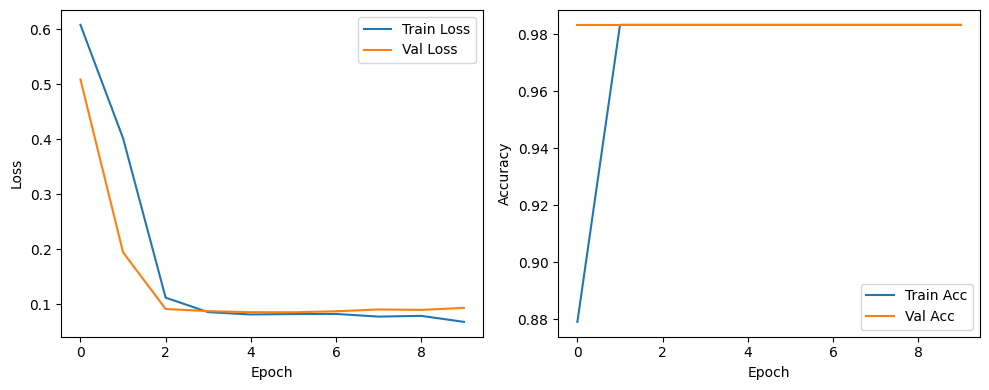

In [64]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))

# Plot loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

# Plot accuracy
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

plt.tight_layout(); plt.show()


In [65]:
model.save('fetal_ecg_lstm_model.h5')

**2.abfecgdb**
**END**

**3. Ultrasound START**

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

img_size = 224
batch_size = 16

# Directories
train_dir ="Ultrasound Fetus Dataset/train"
val_dir ="Ultrasound Fetus Dataset/valid"
test_dir ="Ultrasound Fetus Dataset/test"

# Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    "Ultrasound Fetus Dataset/train",
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = test_val_datagen.flow_from_directory(
    "Ultrasound Fetus Dataset/validation",
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_val_datagen.flow_from_directory(
    "Ultrasound Fetus Dataset/test",
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 1926 images belonging to 3 classes.
Found 341 images belonging to 3 classes.
Found 401 images belonging to 3 classes.


In [2]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze base model
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
output = Dense(3, activation='softmax')(x)  # 3 classes

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,113,027 (91.98 MB)

 Trainable params: 525,315 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [3]:
epochs = 5

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)


C:\Users\KIIT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
121/121 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.6394 - loss: 0.9393 - val_accuracy: 0.7478 - val_loss: 0.6851
Epoch 2/5
121/121 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.7516 - loss: 0.7152 - val_accuracy: 0.7478 - val_loss: 0.6425
Epoch 3/5
121/121 ━━━━━━━━━━━━━━━━━━━━ 115s 951ms/step - accuracy: 0.7377 - loss: 0.7160 - val_accuracy: 0.7478 - val_loss: 0.6302
Epoch 4/5
121/121 ━━━━━━━━━━━━━━━━━━━━ 118s 972ms/step - accuracy: 0.7315 - loss: 0.7037 - val_accuracy: 0.7478 - val_loss: 0.6183
Epoch 5/5
121/121 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.7501 - loss: 0.6690 - val_accuracy: 0.7390 - val_loss: 0.6235


In [4]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Predict on test set
y_probs = model.predict(test_generator)
y_pred = np.argmax(y_probs, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Metrics
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred, average='weighted'))
print("Recall:", recall_score(y_true, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_true, y_pred, average='weighted'))

# Detailed report
print(classification_report(y_true, y_pred, target_names=class_labels))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))


26/26 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step
Accuracy: 0.7406483790523691
Precision: 0.5798592713285676
Recall: 0.7406483790523691
F1 Score: 0.6425490447499735
              precision    recall  f1-score   support

      benign       0.00      0.00      0.00        51
   malignant       0.75      0.99      0.85       300
      normal       0.14      0.02      0.04        50

    accuracy                           0.74       401
   macro avg       0.30      0.34      0.30       401
weighted avg       0.58      0.74      0.64       401

Confusion Matrix:
 [[  0  49   2]
 [  0 296   4]
 [  0  49   1]]


C:\Users\KIIT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\KIIT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\KIIT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classif

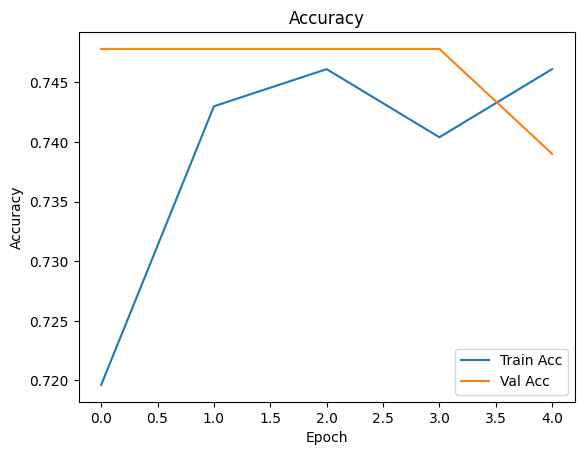

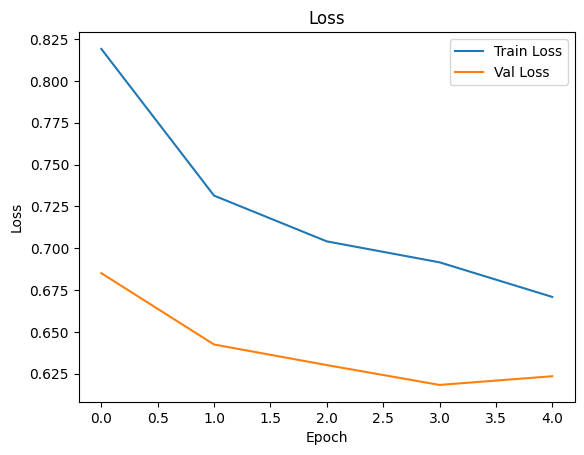

In [5]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


🚫 Skip:

OverlayedImages/ (for now)

.pth file (only for PyTorch)

FetusDataset.csv (optional)

In [6]:
model.save('fetal_ultrasound_classifier.h5')

**3.Ultrasound END**

**4.CTG START**

In [15]:
# pip install openpyxl scikit-learn imbalanced-learn xgboost

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import xgboost as xgb
pd.options.display.max_columns=None
pd.options.display.max_rows=None

# 1️⃣ Load only the "Data" sheet
path = r"C:\Users\KIIT\Desktop\VS_Code\GitHub\Major_Project\CTG.xls"
df = pd.read_excel(path, sheet_name='Data', header=1)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\KIIT\\Desktop\\VS_Code\\GitHub\\Major_Project\\CTG.xls'

In [14]:
df.shape

(1014, 7)

In [34]:
df.drop(columns=['Unnamed: 9','Unnamed: 42','Unnamed: 44','Unnamed: 31'],inplace=True)

In [35]:
df.isnull().sum()

b           3
e           3
AC          3
FM          2
UC          2
DL          1
DS          1
DP          1
DR          1
LB          3
AC.1        3
FM.1        2
UC.1        2
DL.1        1
DS.1        1
DP.1        1
ASTV        2
MSTV        2
ALTV        2
MLTV        2
Width       3
Min         3
Max         3
Nmax        3
Nzeros      3
Mode        3
Mean        3
Median      3
Variance    3
Tendency    3
A           2
B           2
C           2
D           2
E           2
AD          2
DE          2
LD          2
FS          2
SUSP        2
CLASS       3
NSP         3
dtype: int64

In [39]:
df=df.dropna()
df.shape

(2126, 42)

In [41]:
df.isnull().sum().sum()

np.int64(0)

In [ ]:
# 2️⃣ Prepare features and target
X = df.drop(['NSP'], axis=1)
y = df['NSP']  # 1=Normal, 2=Suspect, 3=Pathological
# ...existing code...
# y currently: 1=Normal, 2=Suspect, 3=Pathological
y = y.astype(int) - 1   # map 1,2,3 -> 0,1,2
print("classes after remap:", np.unique(y))
# ...existing code...
# 3️⃣ Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 4️⃣ Scale numeric data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 5️⃣ Balance classes with SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("After SMOTE:", np.bincount(y_train_res))

# 6️⃣ Train models
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test)
print("RandomForest Results:")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
#wrong variables used

classes after remap: [0 1 2]
After SMOTE: [1323 1323 1323]
RandomForest Results:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       332
           1       1.00      0.90      0.95        59
           2       1.00      1.00      1.00        35

    accuracy                           0.99       426
   macro avg       0.99      0.97      0.98       426
weighted avg       0.99      0.99      0.99       426

[[332   0   0]
 [  6  53   0]
 [  0   0  35]]


In [47]:
xgb_clf = xgb.XGBClassifier(n_estimators=200, eval_metric='mlogloss', use_label_encoder=False)
xgb_clf.fit(X_train_res, y_train_res)
y_pred_xgb = xgb_clf.predict(X_test)
print("XGBoost Results:")
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))

C:\Users\KIIT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\training.py:183: UserWarning: [11:18:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Results:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       332
           1       1.00      0.92      0.96        59
           2       1.00      1.00      1.00        35

    accuracy                           0.99       426
   macro avg       1.00      0.97      0.98       426
weighted avg       0.99      0.99      0.99       426

[[332   0   0]
 [  5  54   0]
 [  0   0  35]]


In [50]:
print("\n📊 XGBoost Results:")
print(classification_report(y_test, y_pred_xgb, digits=4))


📊 XGBoost Results:
              precision    recall  f1-score   support

           0     0.9852    1.0000    0.9925       332
           1     1.0000    0.9153    0.9558        59
           2     1.0000    1.0000    1.0000        35

    accuracy                         0.9883       426
   macro avg     0.9951    0.9718    0.9828       426
weighted avg     0.9884    0.9883    0.9880       426



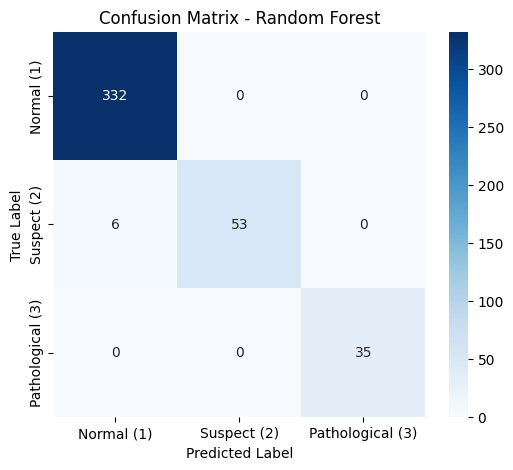

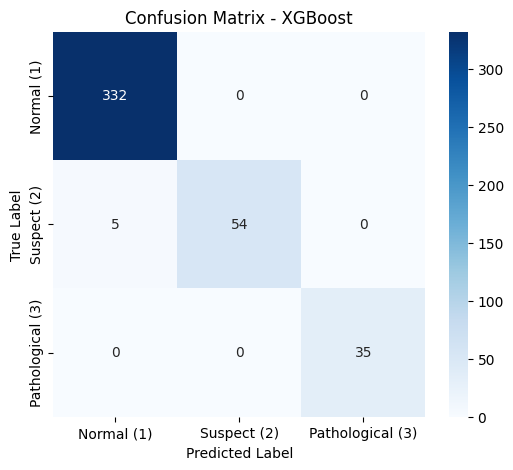

In [53]:
# ---------- CONFUSION MATRIX ----------
import seaborn as sns
def plot_confusion(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    labels = ['Normal (1)', 'Suspect (2)', 'Pathological (3)']
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
plot_confusion(y_test, y_pred_rf, "Random Forest")
plot_confusion(y_test, y_pred_xgb, "XGBoost")

# ---------- FEATURE IMPORTANCE ----------
feature_names = X.columns
importances = rf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

C:\Users\KIIT\AppData\Local\Temp\ipykernel_16884\4115852940.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[sorted_idx][:10], y=feature_names[sorted_idx][:10], palette="viridis")


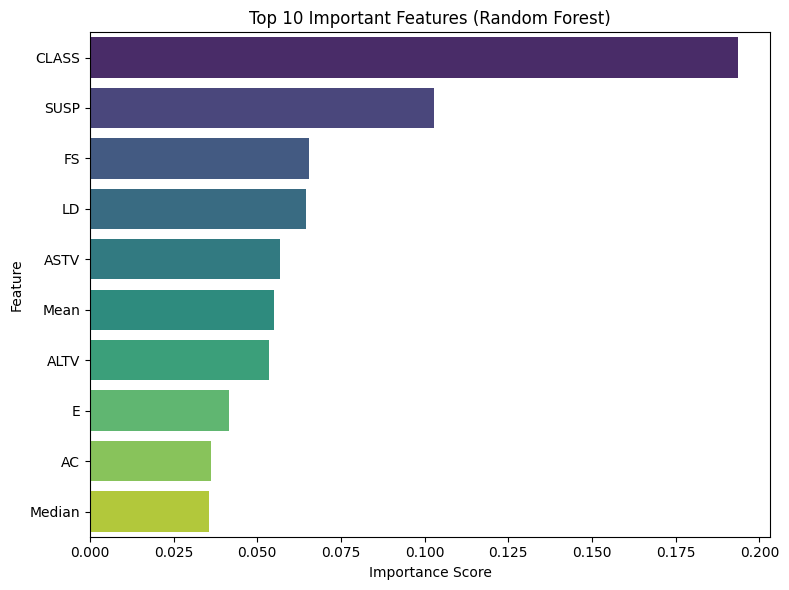

In [54]:
plt.figure(figsize=(8,6))
sns.barplot(x=importances[sorted_idx][:10], y=feature_names[sorted_idx][:10], palette="viridis")
plt.title("Top 10 Important Features (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

C:\Users\KIIT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


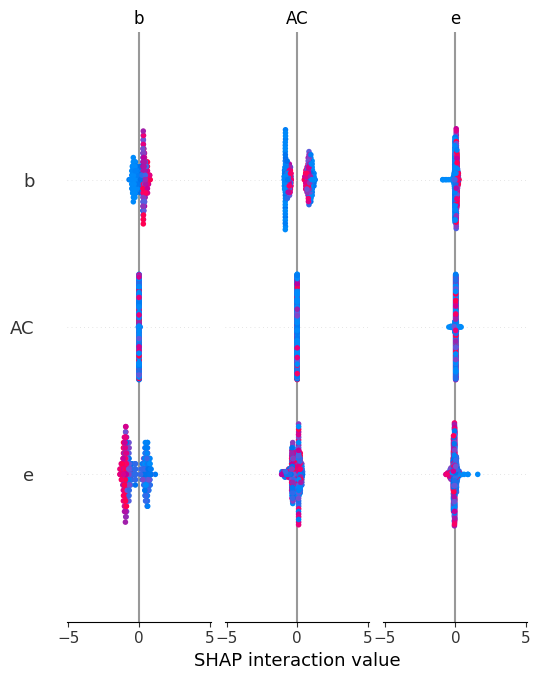

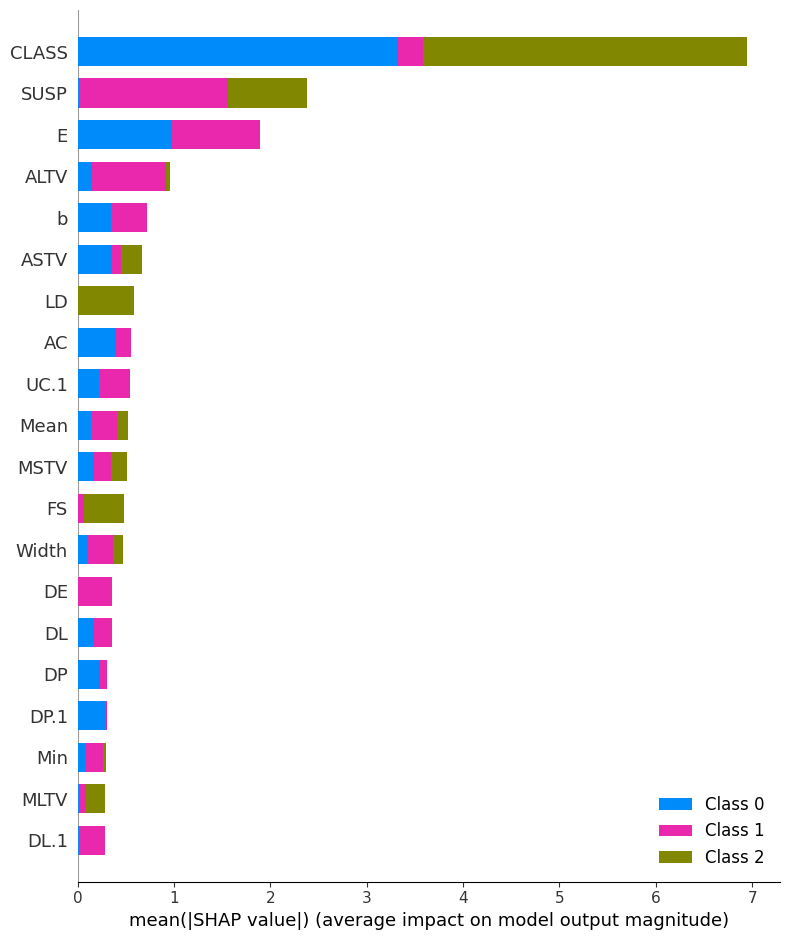


✅ Models and scaler saved successfully.


In [58]:
import shap
import joblib
# ---------- SHAP EXPLAINABILITY ----------
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=feature_names)
shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type="bar")

# ---------- SAVE MODELS ----------
joblib.dump(rf, "ctg_randomforest_model.joblib")
joblib.dump(xgb_clf, "ctg_xgboost_model.joblib")
joblib.dump(scaler, "ctg_scaler.joblib")

print("\n✅ Models and scaler saved successfully.")

**4.CTG END**

This combine part will be removed.

**Combining all models**

In [13]:
import joblib
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Multimodal late-fusion / stacking demo
# Saves a meta-classifier that learns from per-modality model probabilities.
# Assumes maternal models were trained on X_resampled/X_test_scaled (variables exist in notebook).
# If other modality inputs are available and aligned (CTG, ECG LSTM, Ultrasound), extend the predict_* functions and
# include their probability outputs when building train/test feature matrices.


# --- load saved models (skip if not present) ---
loaded = {}
def try_joblib(path, key):
    try:
        loaded[key] = joblib.load(path)
        print(f"Loaded {path}")
    except Exception as e:
        print(f"Skip loading {path}: {e}")

def try_keras(path, key):
    try:
        loaded[key] = load_model(path, compile=False)
        print(f"Loaded {path}")
    except Exception as e:
        print(f"Skip loading {path}: {e}")

try_joblib("maternal_best_rf.joblib", "maternal_best_rf")
try_joblib("maternal_xgboost.joblib", "maternal_xgb")
try_joblib("maternal_scaler.joblib", "maternal_scaler")

try_joblib("ctg_randomforest_model.joblib", "ctg_rf")
try_joblib("ctg_xgboost_model.joblib", "ctg_xgb")
try_joblib("ctg_scaler.joblib", "ctg_scaler")

try_keras("fetal_ecg_lstm_model.h5", "ecg_lstm")
try_keras("fetal_ultrasound_classifier.h5", "us_cnn")

# --- helper to get probability matrix for any model (n_samples, n_classes) ---
def model_proba(model, X):
    """
    Return a (n_samples, n_classes) probability array for given model.
    Works for sklearn estimators and keras models.
    If predict_proba is missing, falls back to predict (one-hot).
    """
    if model is None:
        raise ValueError("model is None")
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)
    # keras model: assume outputs probabilities for multiclass or sigmoid for binary
    if hasattr(model, "predict"):
        p = model.predict(X)
        p = np.asarray(p)
        # If binary and shape (n,1), convert to two-column probs
        if p.ndim == 2 and p.shape[1] == 1:
            p = np.concatenate([1 - p, p], axis=1)
        # If outputs logits, assume already probabilities
        return p
    # fallback to predict -> one-hot
    preds = np.asarray(model.predict(X))
    classes = np.unique(preds)
    onehot = np.zeros((len(preds), classes.max() + 1), dtype=float)
    onehot[np.arange(len(preds)), preds] = 1.0
    return onehot

# --- Build maternal modality probability features (train + test) ---
maternal_models = []
if "maternal_best_rf" in loaded: maternal_models.append(loaded["maternal_best_rf"])
if "maternal_xgb" in loaded: maternal_models.append(loaded["maternal_xgb"])
# include rf from notebook if in memory (falls back to loaded or existing variable)
try:
    # rf may already exist in notebook namespace
    if 'rf' in globals() and globals()['rf'] not in maternal_models:
        maternal_models.append(globals()['rf'])
except Exception:
    pass

if len(maternal_models) == 0:
    raise RuntimeError("No maternal models available for fusion. Ensure maternal_best_rf or maternal_xgboost or rf exist.")

# Prepare train (X_resampled) and test (X_test_scaled) features using saved/available scaler:
# prefer loaded scaler, else use existing 'scaler' variable
if "maternal_scaler" in loaded:
    mat_scaler = loaded["maternal_scaler"]
else:
    mat_scaler = globals().get("scaler", None)

if mat_scaler is None:
    raise RuntimeError("Maternal scaler not found in disk or notebook. Needed to transform tabular maternal features.")

# X_resampled and X_test_scaled should be available in the notebook (from previous cells)
X_train_tab = globals().get("X_resampled", None)
X_test_tab = globals().get("X_test_scaled", None)
y_train_tab = globals().get("y_resampled", None)
y_test_tab = globals().get("y_true", None)  # y_true is maternal test labels exposed in notebook

if X_train_tab is None or X_test_tab is None or y_train_tab is None or y_test_tab is None:
    raise RuntimeError("Required variables X_resampled, X_test_scaled, y_resampled, y_true must exist in the notebook.")

# Compute per-model probabilities and concatenate
train_probas_parts = []
test_probas_parts = []
for m in maternal_models:
    try:
        p_train = model_proba(m, X_train_tab)
        p_test = model_proba(m, X_test_tab)
    except Exception as e:
        # if model expects raw (unscaled) input, try inverse-transform then predict (rare)
        raise RuntimeError(f"Failed to get probabilities from a maternal model: {e}")
    # ensure same number of classes across parts by padding if needed
    train_probas_parts.append(p_train)
    test_probas_parts.append(p_test)

# pad columns so that every part has same number of columns = max_classes
max_cols = max(part.shape[1] for part in train_probas_parts + test_probas_parts)
def pad_cols(arr, max_cols):
    if arr.shape[1] < max_cols:
        pad = np.zeros((arr.shape[0], max_cols - arr.shape[1]))
        return np.hstack([arr, pad])
    return arr

train_parts = [pad_cols(p, max_cols) for p in train_probas_parts]
test_parts = [pad_cols(p, max_cols) for p in test_probas_parts]

X_meta_train = np.hstack(train_parts)
X_meta_test = np.hstack(test_parts)

print("Meta features shape -- train:", X_meta_train.shape, "test:", X_meta_test.shape)

# --- Train a simple meta-classifier on concatenated probabilities ---
meta = LogisticRegression(multi_class='multinomial', max_iter=2000, solver='lbfgs')
meta.fit(X_meta_train, y_train_tab)
y_meta_pred = meta.predict(X_meta_test)

print("Meta fusion results:")
print("Accuracy:", accuracy_score(y_test_tab, y_meta_pred))
print(classification_report(y_test_tab, y_meta_pred, digits=4))

# Save meta model and note which base models were used
joblib.dump({"meta": meta, "base_models": ["maternal_best_rf","maternal_xgb","rf"]}, "multimodal_fusion_meta.joblib")
print("Saved multimodal_fusion_meta.joblib")

# --- Notes / extension points ---
# - To incorporate CTG, ECG (LSTM) and Ultrasound models you must provide aligned training samples across modalities.
#   For each sample produce per-modality probability vectors (using model_proba), then concatenate similarly
#   to X_meta_train/X_meta_test and retrain meta.
# - For image model (us_cnn) you can pass arrays of preprocessed images to model_proba(us_cnn, imgs).
# - For sequence (ecg_lstm) pass shape (n, timesteps, channels) arrays to model_proba(ecg_lstm, X_seq).
# - If modalities have different class orders, ensure consistent class ordering when concatenating probabilities.

Loaded maternal_best_rf.joblib
Loaded maternal_xgboost.joblib
Loaded maternal_scaler.joblib
Loaded ctg_randomforest_model.joblib
Loaded ctg_xgboost_model.joblib
Loaded ctg_scaler.joblib
Loaded fetal_ecg_lstm_model.h5
Loaded fetal_ultrasound_classifier.h5
Meta features shape -- train: (975, 9) test: (203, 9)
Meta fusion results:
Accuracy: 0.8374384236453202
              precision    recall  f1-score   support

           0     0.8608    0.8395    0.8500        81
           1     0.7681    0.7910    0.7794        67
           2     0.8909    0.8909    0.8909        55

    accuracy                         0.8374       203
   macro avg     0.8399    0.8405    0.8401       203
weighted avg     0.8384    0.8374    0.8378       203

Saved multimodal_fusion_meta.joblib


C:\Users\KIIT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
